In [1]:
import numpy as np
from scipy.stats import genpareto
import matplotlib.pyplot as plt
from scipy.stats import expon,poisson
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import seaborn as sns 
import statsmodels.api as sm
import scipy.stats as stats
import Hawkes as hk
import array as arr
from scipy.integrate import quad
import random
from scipy.stats import t
from tqdm import tqdm

plt.rcParams["figure.figsize"] = (20,5)

#from utilsInference import *

C:\Users\nmadhar\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


# I. Joint Simulation Algorithm


In [2]:

def prodInd(j,deltaMatrix):
    vectDelta_j = list(deltaMatrix[:,j])
    vectDelta_j.remove(vectDelta_j[j])
    return np.prod(np.array(vectDelta_j)<0)
def ComputeWk(k,deltaMatrix):
    K = deltaMatrix.shape[0]
    Delta = list(deltaMatrix[k,:])
    Delta.remove(Delta[k])
    Ind = [prodInd(j,deltaMatrix)  for j in range(K) if j != k]
    WwoE = np.dot(np.array(Delta),np.array(Ind))
    return WwoE

def DeltaMatrix(i,DELTA,K):
    deltaMatrix_i = np.zeros((K,K))
    deltaMatrix_i[0,1:] = DELTA.iloc[i,:]
    deltaMatrix_i[:,0] = - deltaMatrix_i[0,:] 
    for k in range(1,K):
        for l in range(k,K):
            if k != l:
                deltaMatrix_i[k,l] = deltaMatrix_i[0,l] - deltaMatrix_i[0,k]
                deltaMatrix_i[l,k] = -deltaMatrix_i[k,l]

    return deltaMatrix_i
## The following function define our joint simulation algorithm 

def simulation(sample,M,replacing=False):
    N,K = sample.shape
    DELTA = pd.DataFrame(columns=np.arange(K-1),index=np.arange(N))
    newSample = pd.DataFrame(columns=np.arange(K),index=np.arange(M))
    for k in range(0,K-1):
        DELTA.iloc[:,k] = sample.iloc[:,0] - sample.iloc[:,k+1]
    if replacing :
        Msample = DELTA.iloc[np.random.choice(list(np.arange(N)),M),:]
    else :
        Msample = DELTA.iloc[random.sample(list(np.arange(N)),M),:]
    E = expon.rvs(size=M)

    for m in range(M):
        deltaMatrix_m = DeltaMatrix(m,Msample,K)
        for k in range(K):
            newSample.iloc[m,k] = E[m] +  ComputeWk(k,deltaMatrix_m)
    return newSample

## II. Parametric Simulation of $T$, $K=3$

$$\mathcal{N}\left(\left(\mu_1,\mu_2\right),\begin{pmatrix}
1 & \rho_{1,2} & \rho_{1,3} \\
\rho_{1,2} & 1 & \rho_{2,3} \\
\rho_{1,3} & \rho_{2,3}  & 1\\
\end{pmatrix}\right),$$

with $\mu_1,\mu_2, \mu_3 = 0$ and $\rho_{1,2}=0.4,\rho_{1,3}=0.8$ and $\rho_{2,3}=0.1$. 


In [3]:
K =  3 # Dimension of random vector 
N = 2000 # size of original sample
M = 10000 # size of sample generated with joint simulation algorithm

# Simulation of original sample under parametric framework where the distribution of the random vector T is known
T = np.random.multivariate_normal(np.zeros(3),cov = np.array([[1,np.sqrt(0.4),np.sqrt(0.8)],
                                                    [np.sqrt(0.4),1,np.sqrt(0.1)],
                                                    [np.sqrt(0.8),np.sqrt(0.1),1]]),size=N)
Tmax = np.array([max(T[i,:]) for i in range(N)])
E = expon.rvs(size=N)
Z = np.zeros((N,3))
Z[:,0] = E + T[:,0] - Tmax
Z[:,1] = E + T[:,1] - Tmax
Z[:,2] = E + T[:,2] - Tmax


# Sample generated with our joint simulation algorihtm 
SimZ_d3 = simulation(pd.DataFrame(Z),M,True)
SimZ_d3.columns = ['Z1','Z2','Z3']

# Original sample 
Zdf = pd.DataFrame(Z)
Zdf.columns = ['Z1','Z2','Z3']




## 1. Scatter Plots 

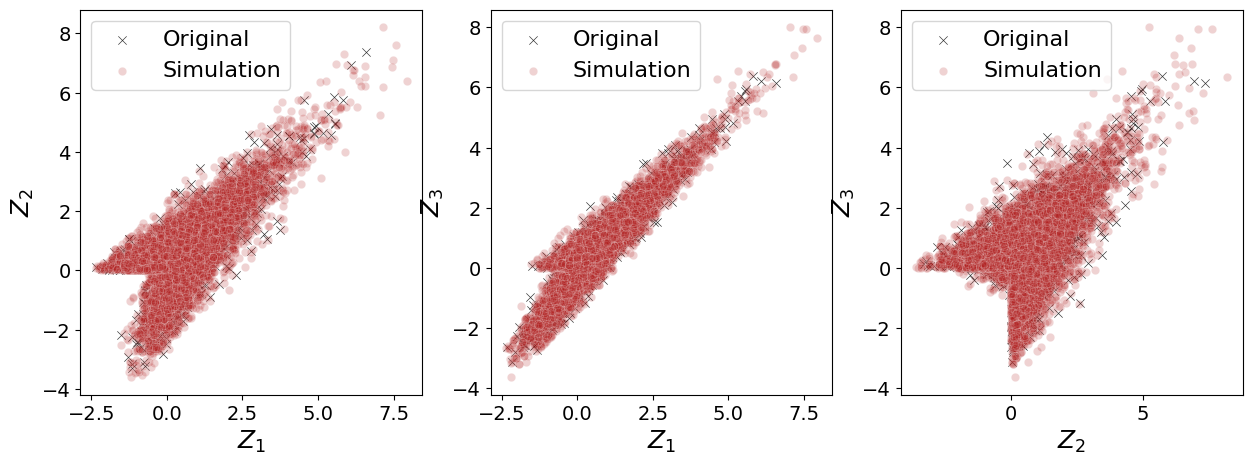

In [8]:
plt.rcParams["figure.figsize"] = (15,5)

_,ax = plt.subplots(1, 3)

sns.scatterplot(data=Zdf,x='Z1',y='Z2',label='Original',ax=ax[0],alpha=0.8,color='black',marker='x')
sns.scatterplot(data=SimZ_d3,x='Z1',y='Z2',label='Simulation',ax=ax[0],alpha=0.2,color='firebrick')
ax[0].set_xlabel('$Z_1$',fontsize=18)
ax[0].set_ylabel('$Z_2$',fontsize=18)
ax[0].tick_params(axis='y', labelsize=14)
ax[0].tick_params(axis='x', labelsize=14)
ax[0].legend(fontsize=16)


sns.scatterplot(data=Zdf,x='Z1',y='Z3',label='Original',ax=ax[1],alpha=0.8,color='black',marker='x')
sns.scatterplot(data=SimZ_d3,x='Z1',y='Z3',label='Simulation',ax=ax[1],alpha=0.2,color='firebrick')
ax[1].set_xlabel('$Z_1$',fontsize=18)
ax[1].set_ylabel('$Z_3$',fontsize=18)
ax[1].tick_params(axis='y', labelsize=14)
ax[1].tick_params(axis='x', labelsize=14)
ax[1].legend(fontsize=16)



sns.scatterplot(data=Zdf,x='Z2',y='Z3',label='Original',ax=ax[2],alpha=0.8,color='black',marker='x')
sns.scatterplot(data=SimZ_d3,x='Z2',y='Z3',label='Simulation',ax=ax[2],alpha=0.2,color='firebrick')
ax[2].set_xlabel('$Z_2$',fontsize=18)
ax[2].set_ylabel('$Z_3$',fontsize=18)
ax[2].tick_params(axis='y', labelsize=14)
ax[2].tick_params(axis='x', labelsize=14)
ax[2].legend(fontsize=16)




In [11]:
%matplotlib qt
fig = plt.figure(figsize=(5,5),constrained_layout=True)
# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
ax = fig.gca(projection='3d')
ax.scatter3D(Z[:,0], Z[:,1], Z[:,2], c='black',alpha=0.3,label='Original',marker='x')
ax.scatter3D(SimZ_d3.iloc[:,0], SimZ_d3.iloc[:,1], SimZ_d3.iloc[:,2], c='firebrick',alpha=0.3,label='Simulation')
ax.set_xlabel('$Z_1$', fontsize=18)
ax.set_ylabel('$Z_2$',fontsize=18)
ax.set_zlabel(r'$Z_3$', fontsize=18)
ax.tick_params(axis='z', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
plt.savefig('test.png', bbox_inches='tight')

C:\Users\nmadhar\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


## 2. QQ Plots with Confidence Intervals 

In [9]:
Qsize = 1000 # number of discretization points used for the QQ plot representation 
B = 1000 # number of bootstrap replication used for the confidence interval

alphaM = (np.linspace(0,0.999,Qsize)*M).astype(int)
alphaN = (np.linspace(0,0.999,Qsize)*N).astype(int)

T = np.random.multivariate_normal(np.zeros(3),cov = np.array([[1,np.sqrt(0.4),np.sqrt(0.8)],
                                                    [np.sqrt(0.4),1,np.sqrt(0.1)],
                                                    [np.sqrt(0.8),np.sqrt(0.1),1]]),size=N)
Tmax = np.array([max(T[i,:]) for i in range(N)])
E = expon.rvs(size=N)
Z = np.zeros((N,3))
Z[:,0] = E + T[:,0] - Tmax
Z[:,1] = E + T[:,1] - Tmax
Z[:,2] = E + T[:,2] - Tmax

In [10]:
level = 0.05 # confidence interval confidence level 
TCritique = t.ppf(1-level/2,df=B-1)
def getParamsCI(Q_CI_SIMU,level):
    qMeanSimu = Q_CI_SIMU.mean().values
    qSTDSimu = Q_CI_SIMU.std().values
    SEM = qSTDSimu

    IC_Low =  qMeanSimu - TCritique*SEM
    IC_UP =  qMeanSimu + TCritique*SEM
    return qMeanSimu,SEM,IC_Low,IC_UP

def plotQQPlot_CI(Qtrue,qMeanSimu,SEM,IC_Low,IC_UP,xlabel='$Z_1$',ylabel='$\widetilde{Z}_1$'):
    fig, ax = plt.subplots()
    ax.scatter(Qtrue, qMeanSimu,color='darkolivegreen',marker='D',s=20)
    ax.fill_between(Qtrue, IC_Low, IC_UP, color='red', alpha=.2)
    ax.axline((0, 0), slope=1,linestyle='-.',c='grey')
    ax.set_xlabel(xlabel,fontsize=18)
    ax.set_ylabel(ylabel,fontsize=18)
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)




In [164]:
Q_CI_SIMUZ1 = pd.DataFrame(np.zeros((B,Qsize)))
Q_CI_SIMUZ2 = pd.DataFrame(np.zeros((B,Qsize)))
Q_CI_SIMUZ3 = pd.DataFrame(np.zeros((B,Qsize)))

for m in tqdm(range(B)):
    SimZ_d3 = simulation(pd.DataFrame(Z),M,True)
    SimZ_d3.columns = ['Z1','Z2','Z3']
    QSimuZ1 = np.sort(SimZ_d3.iloc[:,0])[alphaM]
    Q_CI_SIMUZ1.iloc[m,:] = QSimuZ1
    
    QSimuZ2 = np.sort(SimZ_d3.iloc[:,1])[alphaM]
    Q_CI_SIMUZ2.iloc[m,:] = QSimuZ2
    
    QSimuZ3 = np.sort(SimZ_d3.iloc[:,2])[alphaM]
    Q_CI_SIMUZ3.iloc[m,:] = QSimuZ3
    
qMeanSimu_Z1,SEM_Z1,IC_Low_Z1,IC_UP_Z1 = getParamsCI(Q_CI_SIMUZ1,level)
qMeanSimu_Z2,SEM_Z2,IC_Low_Z2,IC_UP_Z2 = getParamsCI(Q_CI_SIMUZ2,level)
qMeanSimu_Z3,SEM_Z3,IC_Low_Z3,IC_UP_Z3 = getParamsCI(Q_CI_SIMUZ3,level)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:21:30<00:00,  4.46s/it]


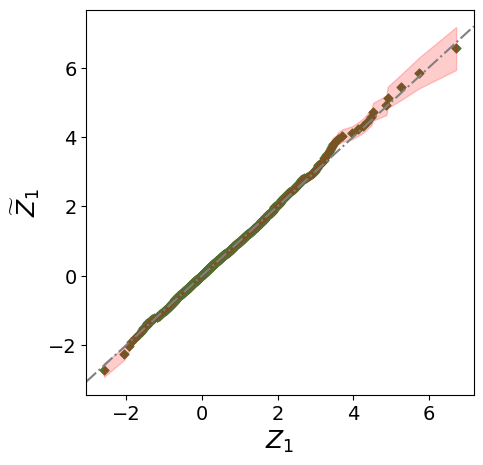

In [169]:
QTRUE = np.sort(Z[:,0])[alphaN]
plotQQPlot_CI(QTRUE,qMeanSimu_Z1,SEM_Z1,IC_Low_Z1,IC_UP_Z1,xlabel='$Z_1$',ylabel='$\widetilde{Z}_1$')


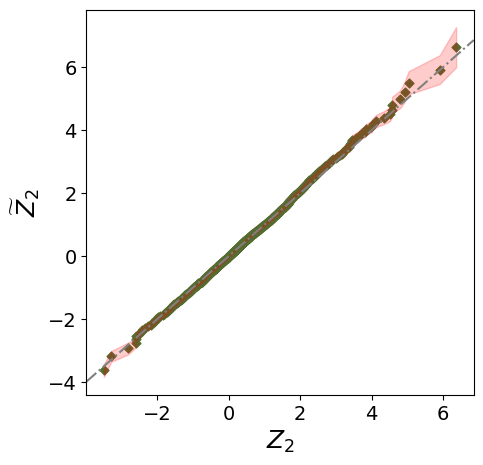

In [170]:
QTRUE_Z2 = np.sort(Z[:,1])[alphaN]
plotQQPlot_CI(QTRUE_Z2,qMeanSimu_Z2,SEM_Z2,IC_Low_Z2,IC_UP_Z2,xlabel='$Z_2$',ylabel='$\widetilde{Z}_2$')


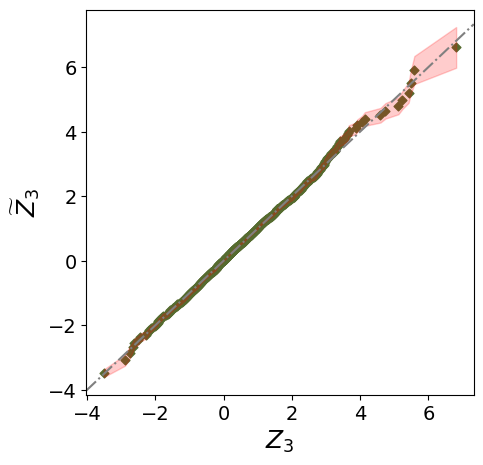

In [171]:
QTRUE_Z3 = np.sort(Z[:,2])[alphaN]
plotQQPlot_CI(QTRUE_Z3,qMeanSimu_Z3,SEM_Z3,IC_Low_Z3,IC_UP_Z3,xlabel='$Z_3$',ylabel='$\widetilde{Z}_3$')
